## Preprocessing an audio dataset

Loading a dataset with 🤗 Datasets is just half of the fun. If you plan to use it either for training a model, or for running inference, you will need to pre-process the data first. In general, this will involve the following steps:

- Resampling the audio data
- Filtering the dataset
- Converting audio data to model’s expected input

In [1]:
!pip install -q datasets[audio] librosa transformers

### Resampling the audio data

The load_dataset function downloads audio examples with the sampling rate that they were published with. This is not always the sampling rate expected by a model you plan to train, or use for inference. If there’s a discrepancy between the sampling rates, you can resample the audio to the model’s expected sampling rate.

Most of the available pretrained models have been pretrained on audio datasets at a sampling rate of 16 kHz. When we explored MINDS-14 dataset, you may have noticed that it is sampled at 8 kHz, which means we will likely need to upsample it.

To do so, use 🤗 Datasets’ cast_column method. This operation does not change the audio in-place, but rather signals to datasets to resample the audio examples on the fly when they are loaded. The following code will set the sampling rate to 16kHz:

In [2]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [3]:
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

In [4]:
from datasets import Audio

minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

# reload first audio example in MINDS-14 and check if has been resamled to desired
# sampling rate
minds[0]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/f9018fd3747971e77d59e6c5da3fdf9d5bb914c495e16c23e1fe47c921d76a7a/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/f9018fd3747971e77d59e6c5da3fdf9d5bb914c495e16c23e1fe47c921d76a7a/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.36119668e-05, 1.92324660e-04, 2.19284790e-04, ...,
         9.40907281e-04, 1.16613181e-03, 7.20883254e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

You may notice that the array values are now also different. This is because we’ve now got twice the number of amplitude values for every one that we had before.

> 💡 Some background on resampling: If an audio signal has been sampled at 8 kHz, so that it has 8000 sample readings per second, we know that the audio does not contain any frequencies over 4 kHz. This is guaranteed by the Nyquist sampling theorem. Because of this, we can be certain that in between the sampling points the original continuous signal always makes a smooth curve. Upsampling to a higher sampling rate is then a matter of calculating additional sample values that go in between the existing ones, by approximating this curve. Downsampling, however, requires that we first filter out any frequencies that would be higher than the new Nyquist limit, before estimating the new sample points. In other words, you can't downsample by a factor 2x by simply throwing away every other sample — this will create distortions in the signal called aliases. Doing resampling correctly is tricky and best left to well-tested libraries such as librosa or 🤗 Datasets.

### Filtering the dataset

You may need to filter the data based on some criteria. **One of the common cases involves limiting the audio examples to a certain duration. For instance, we might want to filter out any examples longer than 20s to prevent out-of-memory errors when training a model.**

We can do this by using the 🤗 Datasets’ filter method and passing a function with filtering logic to it. Let’s start by writing a function that indicates which examples to keep and which to discard. **This function, is_audio_length_in_range, returns True if a sample is shorter than 20s, and False if it is longer than 20s.**

In [5]:
MAX_DURATION_IN_SECONDS = 20.0

def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

The filtering function can be applied to a dataset’s column but we do not have a column with audio track duration in this dataset. However, we can create one, filter based on the values in that column, and then remove it.



In [6]:
import librosa

# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 624
})

We can verify that dataset has been filtered down from 654 examples to 624.



### Pre-processing audio data

One of the most challenging aspects of working with audio datasets is preparing the data in the right format for model training. **As you saw, the raw audio data comes as an array of sample values. However, pre-trained models, whether you use them for inference, or want to fine-tune them for your task, expect the raw data to be converted into input features. The requirements for the input features may vary from one model to another — they depend on the model’s architecture, and the data it was pre-trained with. The good news is, for every supported audio model, 🤗 Transformers offer a feature extractor class that can convert raw audio data into the input features the model expects.**

So what does a feature extractor do with the raw audio data? Let’s take a look at Whisper’s feature extractor to understand some common feature extraction transformations.

**Whisper is a pre-trained model for automatic speech recognition (ASR) published in September 2022 by Alec Radford et al. from OpenAI.**

1. First, the **Whisper feature extractor pads/truncates a batch of audio examples such that all examples have an input length of 30s.** Examples shorter than this are padded to 30s by appending zeros to the end of the sequence (zeros in an audio signal correspond to no signal or silence). Examples longer than 30s are truncated to 30s.
Since all elements in the batch are padded/truncated to a maximum length in the input space, there is no need for an attention mask. Whisper is unique in this regard, most other audio models require an attention mask that details where sequences have been padded, and thus where they should be ignored in the self-attention mechanism. Whisper is trained to operate without an attention mask and infer directly from the speech signals where to ignore the inputs.

2. The second operation that the Whisper feature extractor performs is **converting the padded audio arrays to log-mel spectrograms.** As you recall, these spectrograms describe how the frequencies of a signal change over time, expressed on the mel scale and measured in decibels (the log part) to make the frequencies and amplitudes more representative of human hearing.

All these transformations can be applied to your raw audio data with a couple of lines of code. Let’s go ahead and load the feature extractor from the pre-trained Whisper checkpoint to have ready for our audio data:

In [7]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

Next, you can write a function to pre-process a single audio example by passing it through the feature_extractor.



In [8]:
def prepare_dataset(example):
  audio = example["audio"]
  features = feature_extractor(
      audio["array"], sampling_rate=audio["sampling_rate"], padding=True
  )
  return features

We can apply the data preparation function to all of our training examples using 🤗 Datasets’ map method:



In [9]:
minds = minds.map(prepare_dataset)
minds

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 624
})

As easy as that, we now have log-mel spectrograms as input_features in the dataset.

Let’s visualize it for one of the examples in the minds dataset:

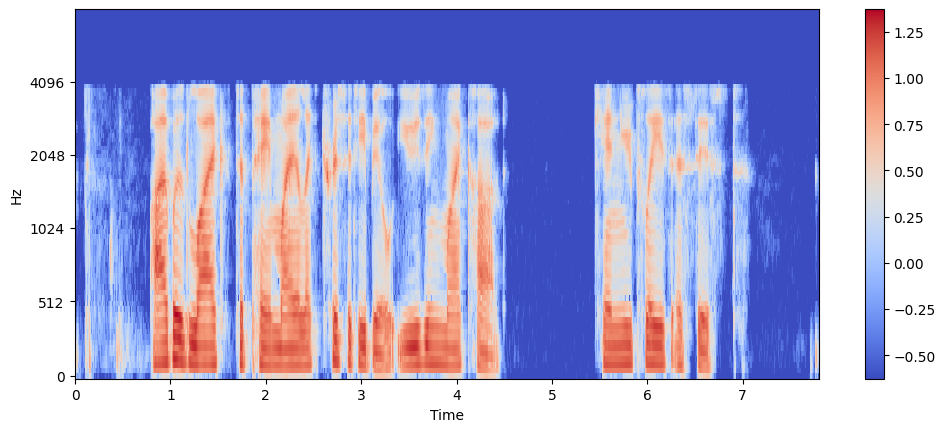

In [10]:
import numpy as np
import matplotlib.pyplot as plt

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

Now you can see what the audio input to the Whisper model looks like after preprocessing.

The model’s feature extractor class takes care of transforming raw audio data to the format that the model expects. However, many tasks involving audio are multimodal, e.g. speech recognition. In such cases 🤗 Transformers also offer model-specific tokenizers to process the text inputs. For a deep dive into tokenizers, please refer to our NLP course.

**You can load the feature extractor and tokenizer for Whisper and other multimodal models separately, or you can load both via a so-called processor. To make things even simpler, use AutoProcessor to load a model’s feature extractor and processor from a checkpoint, like this:**



```
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/whisper-small")
```

Here we have illustrated the fundamental data preparation steps. Of course, custom data may require more complex preprocessing. In this case, you can extend the function prepare_dataset to perform any sort of custom data transformations. With 🤗 Datasets, if you can write it as a Python function, you can apply it to your dataset!



## Streaming audio data

One of the biggest challenges faced with audio datasets is their **sheer size. A single minute of uncompressed CD-quality audio (44.1kHz, 16-bit) takes up a bit more than 5 MB of storage. Typically, an audio dataset would contains hours of recordings.**

In the previous sections we used a very small subset of MINDS-14 audio dataset, however, typical audio datasets are much larger. For example, the xs (smallest) configuration of GigaSpeech from **SpeechColab contains only 10 hours of training data, but takes over 13GB of storage space for download and preparation. So what happens when we want to train on a larger split? The full xl configuration of the same dataset contains 10,000 hours of training data, requiring over 1TB of storage space.** For most of us, this well exceeds the specifications of a typical hard drive disk. Do we need to fork out and buy additional storage? Or is there a way we can train on these datasets with no disk space constraints?

🤗 Datasets comes to the rescue by offering the streaming mode. **Streaming allows us to load the data progressively as we iterate over the dataset. Rather than downloading the whole dataset at once, we load the dataset one example at a time. We iterate over the dataset, loading and preparing examples on the fly when they are needed.** This way, we only ever load the examples that we’re using, and not the ones that we’re not! Once we’re done with an example sample, we continue iterating over the dataset and load the next one.

Streaming mode has three primary advantages over downloading the entire dataset at once:

- Disk space: examples are loaded to memory one-by-one as we iterate over the dataset. Since the data is not downloaded locally, there are no disk space requirements, so you can use datasets of arbitrary size.
- Download and processing time: audio datasets are large and need a significant amount of time to download and process. With streaming, loading and processing is done on the fly, meaning you can start using the dataset as soon as the first example is ready.
- Easy experimentation: you can experiment on a handful of examples to check that your script works without having to download the entire dataset.

**There is one caveat to streaming mode. When downloading a full dataset without streaming, both the raw data and processed data are saved locally to disk. If we want to re-use this dataset, we can directly load the processed data from disk, skipping the download and processing steps. Consequently, we only have to perform the downloading and processing operations once, after which we can re-use the prepared data.**

With streaming mode, the data is not downloaded to disk. Thus, neither the downloaded nor pre-processed data are cached. If we want to re-use the dataset, the streaming steps must be repeated, with the audio files loaded and processed on the fly again. For this reason, it is advised to download datasets that you are likely to use multiple times.

How can you enable streaming mode? Easy! Just set streaming=True when you load your dataset. The rest will be taken care for you:

In [12]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [13]:
# access first in hf repo
gigaspeech = load_dataset("speechcolab/gigaspeech", "xs", streaming=True)

gigaspeech.py:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

The repository for speechcolab/gigaspeech contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/speechcolab/gigaspeech.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Just like we applied preprocessing steps to a downloaded subset of MINDS-14, you can do the same preprocessing with a streaming dataset in the exactly the same manner.

**The only difference is that you can no longer access individual samples using Python indexing (i.e. gigaspeech["train"][sample_idx]). Instead, you have to iterate over the dataset.** Here’s how you can access an example when streaming a dataset:

In [14]:
next(iter(gigaspeech["train"]))

{'segment_id': 'YOU0000000315_S0000660',
 'speaker': 'N/A',
 'text': "AS THEY'RE LEAVING <COMMA> CAN KASH PULL ZAHRA ASIDE REALLY QUICKLY <QUESTIONMARK>",
 'audio': {'path': 'xs_chunks_0000/YOU0000000315_S0000660.wav',
  'array': array([0.0005188 , 0.00085449, 0.00012207, ..., 0.00125122, 0.00076294,
         0.00036621]),
  'sampling_rate': 16000},
 'begin_time': 2941.89,
 'end_time': 2945.07,
 'audio_id': 'YOU0000000315',
 'title': 'Return to Vasselheim | Critical Role: VOX MACHINA | Episode 43',
 'url': 'https://www.youtube.com/watch?v=zr2n1fLVasU',
 'source': 2,
 'category': 24,
 'original_full_path': 'audio/youtube/P0004/YOU0000000315.opus'}

If you’d like to preview **several examples from a large dataset, use the take() to get the first n elements.** Let’s grab the first two examples in the gigaspeech dataset:



In [15]:
gigaspeech_head = gigaspeech["train"].take(2)
list(gigaspeech_head)

[{'segment_id': 'YOU0000000315_S0000660',
  'speaker': 'N/A',
  'text': "AS THEY'RE LEAVING <COMMA> CAN KASH PULL ZAHRA ASIDE REALLY QUICKLY <QUESTIONMARK>",
  'audio': {'path': 'xs_chunks_0000/YOU0000000315_S0000660.wav',
   'array': array([0.0005188 , 0.00085449, 0.00012207, ..., 0.00125122, 0.00076294,
          0.00036621]),
   'sampling_rate': 16000},
  'begin_time': 2941.89,
  'end_time': 2945.07,
  'audio_id': 'YOU0000000315',
  'title': 'Return to Vasselheim | Critical Role: VOX MACHINA | Episode 43',
  'url': 'https://www.youtube.com/watch?v=zr2n1fLVasU',
  'source': 2,
  'category': 24,
  'original_full_path': 'audio/youtube/P0004/YOU0000000315.opus'},
 {'segment_id': 'AUD0000001043_S0000775',
  'speaker': 'N/A',
  'text': 'SIX TOMATOES <PERIOD>',
  'audio': {'path': 'xs_chunks_0000/AUD0000001043_S0000775.wav',
   'array': array([ 1.43432617e-03,  1.37329102e-03,  1.31225586e-03, ...,
          -6.10351562e-05, -1.22070312e-04, -1.83105469e-04]),
   'sampling_rate': 16000},
 

Streaming mode can take your research to the next level: not only are the biggest datasets accessible to you, but you can easily evaluate systems over multiple datasets in one go without worrying about your disk space. Compared to evaluating on a single dataset, multi-dataset evaluation gives a better metric for the generalisation abilities of a speech recognition system **(c.f. End-to-end Speech Benchmark (ESB)).**



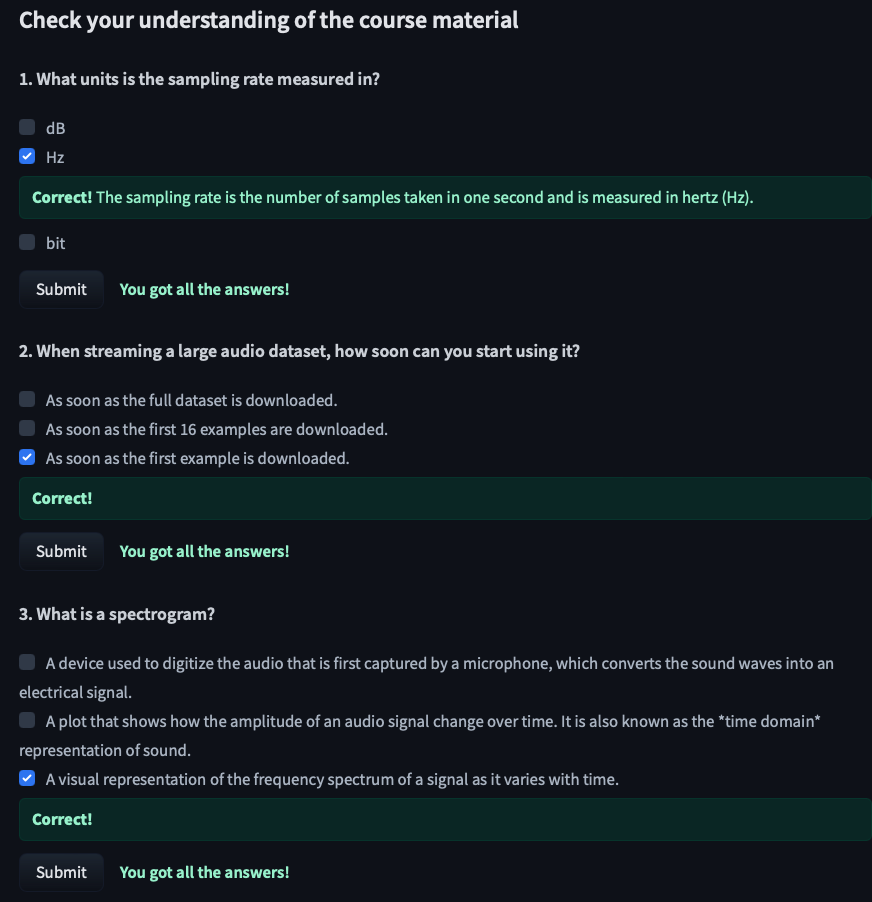

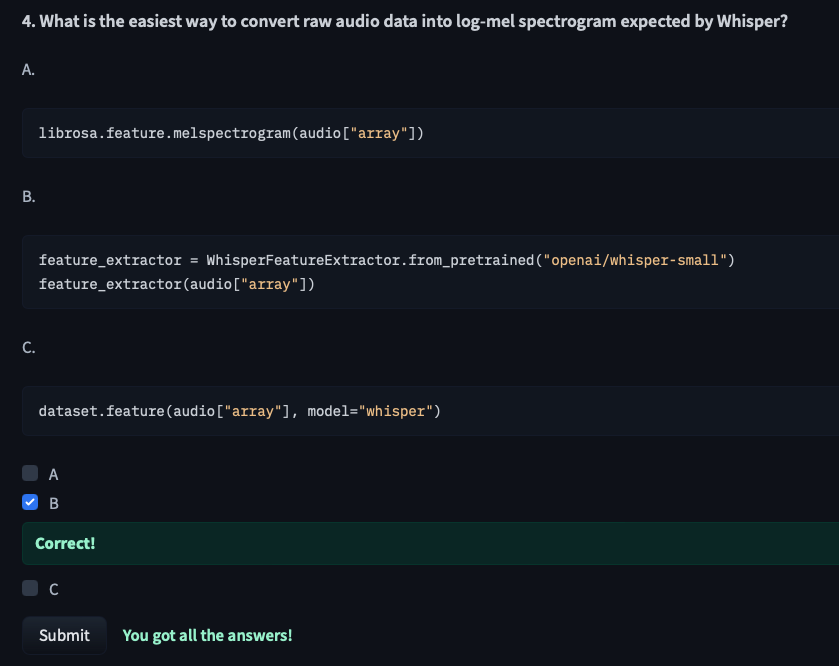

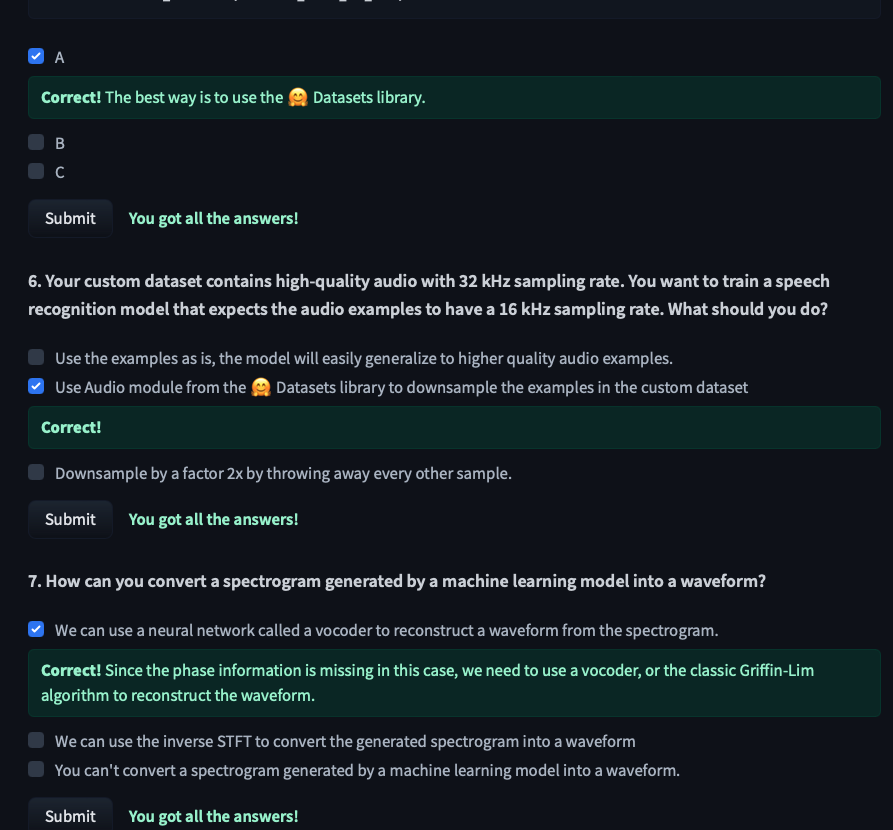